In [101]:
import sys
import torch
import torchvision.models as models
import torchvision
import torchvision.transforms as transforms
from download_dataset import get_train_dataset_path, get_test_dataset_path
import numpy as np
import pandas as pd
import os
import torch.optim as optim
import torch.nn as nn
import sys
import argparse
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR
import random
from few_shot_embedder import FewShotEmbedder
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, RandomSampler
from torchvision import datasets, transforms
import numpy as np
import gc
from torch.nn.functional import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
class ResNet18Embedder(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = models.resnet18(weights='IMAGENET1K_V1')
        
        self.resnet.fc = nn.Identity()
        
        self.pool_and_flatten = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten()
        )
        
        self._freeze_layers()
    
    def _freeze_layers(self):
        for param in self.resnet.parameters():
            param.requires_grad = False
        for param in self.resnet.layer4.parameters():
            param.requires_grad = True
    
    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)
        
        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)
        
        x = self.pool_and_flatten(x)
        return x

def load_resnet():
    return ResNet18Embedder()

In [163]:
def load_custom():
    state_dict = torch.load('checkpoint_epoch15.pth', map_location=torch.device('cpu'))['model_state']
    model = FewShotEmbedder()
    model.load_state_dict(state_dict)
    return model

In [ ]:
def create_class_dataloaders(data_path, batch_size, num_workers=2):
    cinic_mean = [0.47889522, 0.47227842, 0.43047404]
    cinic_std = [0.24205776, 0.23828046, 0.25874835]
    
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=cinic_mean, std=cinic_std)
    ])
    
    dataset = datasets.ImageFolder(data_path, transform=transform)
    
    class_indices = {i: [] for i in range(len(dataset.classes))}
    for idx, (_, label) in enumerate(dataset):
        class_indices[label].append(idx)
    
    class_loaders = {}
    for class_idx, indices in class_indices.items():
        subset = Subset(dataset, indices)
        loader = DataLoader(
            subset,
            batch_size=batch_size,
            sampler=RandomSampler(subset, replacement=True),
            num_workers=min(2, num_workers),
            pin_memory=True,
            persistent_workers=False
        )
        class_loaders[class_idx] = loader
    
    return class_loaders, dataset.classes


In [165]:
model = load_custom()

In [143]:
model = load_resnet()

In [166]:
S = 16
Q = 32
M = 4

batch_size = S + Q

In [167]:
def calculate_avg_accuracy(model, data_loaders, class_names, S, Q, M):
    cls = np.random.choice(class_names, replace=False, size=M)
    idx = [class_names.index(c) for c in cls]

    data = {}
    for i, class_name in zip(idx, cls):
        try:
            batch = next(iter(data_loaders[i]))[0]
        except:
            continue
        support_batch = batch[:S]
        query_batch = batch[S:]

        with torch.no_grad():
            support_embed = model(support_batch)
            query_embed = model(query_batch)
        
        supp_mean = support_embed.mean(axis=0)
        data[str(class_name)] = {
            'embed_mean': supp_mean,
            'query_embed': query_embed
        }
    
    class_names = []
    class_means = []
    for class_name, class_data in data.items():
        class_names.append(class_name)
        class_means.append(class_data['embed_mean'])
        
    class_means_tensor = torch.stack(class_means)

    predictions = {}
    for class_name, class_data in data.items():
        query_embeddings = class_data['query_embed']
        
        similarities = cosine_similarity(
            query_embeddings.unsqueeze(1),
            class_means_tensor.unsqueeze(0),
            dim=2
        )
        
        _, pred_classes = torch.max(similarities, dim=1)
        
        pred_class_names = [class_names[idx] for idx in pred_classes.tolist()]
        
        predictions[class_name] = pred_class_names
    
    correct_predictions = [(key, int(np.sum(np.array(predictions[key]) == key))) for key in predictions]
    avg_accuracy = sum([x[1] for x in correct_predictions]) / (M*Q)

    return avg_accuracy

In [168]:
def create_accuracy_hist_plot(model, S, Q, M, num_experiments=100):
    data_loaders = create_class_dataloaders(get_test_dataset_path(), batch_size, 2)
    data_loaders, class_names = data_loaders
    
    avg_accuracies = []
    for i in range(num_experiments):
        if i % 10 == 0:
            print(f'{i} / {num_experiments}')
        acc = calculate_avg_accuracy(model, data_loaders, class_names, S, Q, M)
        avg_accuracies.append(acc)
    
    plt.figure(figsize=(10, 6))
    
    ax = sns.histplot(
        avg_accuracies,
        bins=20,
        kde=False,
        color='royalblue',
        edgecolor='white',
        linewidth=1,
        alpha=0.7
    )
    
    mean_acc = np.mean(avg_accuracies)
    plt.axvline(mean_acc, color='crimson', linestyle='--', linewidth=2)
    
    plt.text(
        mean_acc + 0.01, plt.ylim()[1]*0.9,
        f'Mean: {mean_acc:.2f}',
        color='crimson',
        fontsize=12
    )
    
    plt.xlabel('Accuracy', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title(f'Accuracy distribution for S={S}, M={M}, Q={Q}', fontsize=14, pad=20)
    
    ax.set_facecolor('#f5f5f5')
    plt.grid(True, linestyle='--', alpha=0.3)
    
    sns.despine()
    
    plt.tight_layout()

0 / 1000
10 / 1000
20 / 1000
30 / 1000
40 / 1000
50 / 1000
60 / 1000
70 / 1000


Traceback (most recent call last):
  File "/home/dawid/.pyenv/versions/3.11.8/lib/python3.11/multiprocessing/util.py", line 303, in _run_finalizers
    finalizer()
  File "/home/dawid/.pyenv/versions/3.11.8/lib/python3.11/multiprocessing/util.py", line 227, in __call__
    res = self._callback(*self._args, **self._kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dawid/.pyenv/versions/3.11.8/lib/python3.11/multiprocessing/util.py", line 136, in _remove_temp_dir
    rmtree(tempdir, onerror=onerror)
  File "/home/dawid/.pyenv/versions/3.11.8/lib/python3.11/shutil.py", line 763, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/home/dawid/.pyenv/versions/3.11.8/lib/python3.11/shutil.py", line 761, in rmtree
    os.rmdir(path, dir_fd=dir_fd)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-t_k7zst9'


80 / 1000
90 / 1000
100 / 1000
110 / 1000


Traceback (most recent call last):
  File "/home/dawid/.pyenv/versions/3.11.8/lib/python3.11/multiprocessing/util.py", line 303, in _run_finalizers
    finalizer()
  File "/home/dawid/.pyenv/versions/3.11.8/lib/python3.11/multiprocessing/util.py", line 227, in __call__
    res = self._callback(*self._args, **self._kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dawid/.pyenv/versions/3.11.8/lib/python3.11/multiprocessing/util.py", line 136, in _remove_temp_dir
    rmtree(tempdir, onerror=onerror)
  File "/home/dawid/.pyenv/versions/3.11.8/lib/python3.11/shutil.py", line 763, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/home/dawid/.pyenv/versions/3.11.8/lib/python3.11/shutil.py", line 761, in rmtree
    os.rmdir(path, dir_fd=dir_fd)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-fzrrqrx1'


120 / 1000
130 / 1000


Traceback (most recent call last):
  File "/home/dawid/.pyenv/versions/3.11.8/lib/python3.11/multiprocessing/util.py", line 303, in _run_finalizers
    finalizer()
  File "/home/dawid/.pyenv/versions/3.11.8/lib/python3.11/multiprocessing/util.py", line 227, in __call__
    res = self._callback(*self._args, **self._kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dawid/.pyenv/versions/3.11.8/lib/python3.11/multiprocessing/util.py", line 136, in _remove_temp_dir
    rmtree(tempdir, onerror=onerror)
  File "/home/dawid/.pyenv/versions/3.11.8/lib/python3.11/shutil.py", line 763, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/home/dawid/.pyenv/versions/3.11.8/lib/python3.11/shutil.py", line 761, in rmtree
    os.rmdir(path, dir_fd=dir_fd)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-1gmae1ak'


140 / 1000
150 / 1000
160 / 1000
170 / 1000
180 / 1000


Traceback (most recent call last):
  File "/home/dawid/.pyenv/versions/3.11.8/lib/python3.11/multiprocessing/util.py", line 303, in _run_finalizers
    finalizer()
  File "/home/dawid/.pyenv/versions/3.11.8/lib/python3.11/multiprocessing/util.py", line 227, in __call__
    res = self._callback(*self._args, **self._kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dawid/.pyenv/versions/3.11.8/lib/python3.11/multiprocessing/util.py", line 136, in _remove_temp_dir
    rmtree(tempdir, onerror=onerror)
  File "/home/dawid/.pyenv/versions/3.11.8/lib/python3.11/shutil.py", line 763, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/home/dawid/.pyenv/versions/3.11.8/lib/python3.11/shutil.py", line 761, in rmtree
    os.rmdir(path, dir_fd=dir_fd)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-lopmnvuv'


190 / 1000
200 / 1000
210 / 1000
220 / 1000
230 / 1000
240 / 1000
250 / 1000


Traceback (most recent call last):
  File "/home/dawid/.pyenv/versions/3.11.8/lib/python3.11/multiprocessing/util.py", line 303, in _run_finalizers
    finalizer()
  File "/home/dawid/.pyenv/versions/3.11.8/lib/python3.11/multiprocessing/util.py", line 227, in __call__
    res = self._callback(*self._args, **self._kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dawid/.pyenv/versions/3.11.8/lib/python3.11/multiprocessing/util.py", line 136, in _remove_temp_dir
    rmtree(tempdir, onerror=onerror)
  File "/home/dawid/.pyenv/versions/3.11.8/lib/python3.11/shutil.py", line 763, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/home/dawid/.pyenv/versions/3.11.8/lib/python3.11/shutil.py", line 761, in rmtree
    os.rmdir(path, dir_fd=dir_fd)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-pzsaslqj'


260 / 1000
270 / 1000
280 / 1000
290 / 1000
300 / 1000
310 / 1000
320 / 1000
330 / 1000
340 / 1000
350 / 1000
360 / 1000
370 / 1000
380 / 1000
390 / 1000
400 / 1000
410 / 1000
420 / 1000
430 / 1000
440 / 1000
450 / 1000


Traceback (most recent call last):
  File "/home/dawid/.pyenv/versions/3.11.8/lib/python3.11/multiprocessing/util.py", line 303, in _run_finalizers
    finalizer()
  File "/home/dawid/.pyenv/versions/3.11.8/lib/python3.11/multiprocessing/util.py", line 227, in __call__
    res = self._callback(*self._args, **self._kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dawid/.pyenv/versions/3.11.8/lib/python3.11/multiprocessing/util.py", line 136, in _remove_temp_dir
    rmtree(tempdir, onerror=onerror)
  File "/home/dawid/.pyenv/versions/3.11.8/lib/python3.11/shutil.py", line 763, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/home/dawid/.pyenv/versions/3.11.8/lib/python3.11/shutil.py", line 761, in rmtree
    os.rmdir(path, dir_fd=dir_fd)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-thzjy7lb'


460 / 1000
470 / 1000
480 / 1000


Traceback (most recent call last):
  File "/home/dawid/.pyenv/versions/3.11.8/lib/python3.11/multiprocessing/util.py", line 303, in _run_finalizers
    finalizer()
  File "/home/dawid/.pyenv/versions/3.11.8/lib/python3.11/multiprocessing/util.py", line 227, in __call__
    res = self._callback(*self._args, **self._kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dawid/.pyenv/versions/3.11.8/lib/python3.11/multiprocessing/util.py", line 136, in _remove_temp_dir
    rmtree(tempdir, onerror=onerror)
  File "/home/dawid/.pyenv/versions/3.11.8/lib/python3.11/shutil.py", line 763, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/home/dawid/.pyenv/versions/3.11.8/lib/python3.11/shutil.py", line 761, in rmtree
    os.rmdir(path, dir_fd=dir_fd)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-qfhgwsrm'


490 / 1000
500 / 1000
510 / 1000
520 / 1000
530 / 1000
540 / 1000
550 / 1000
560 / 1000
570 / 1000
580 / 1000
590 / 1000
600 / 1000
610 / 1000
620 / 1000
630 / 1000
640 / 1000
650 / 1000
660 / 1000
670 / 1000
680 / 1000
690 / 1000
700 / 1000
710 / 1000
720 / 1000
730 / 1000
740 / 1000
750 / 1000
760 / 1000
770 / 1000
780 / 1000
790 / 1000
800 / 1000
810 / 1000
820 / 1000
830 / 1000
840 / 1000
850 / 1000
860 / 1000
870 / 1000
880 / 1000
890 / 1000
900 / 1000
910 / 1000
920 / 1000
930 / 1000
940 / 1000
950 / 1000
960 / 1000
970 / 1000
980 / 1000
990 / 1000


Traceback (most recent call last):
  File "/home/dawid/.pyenv/versions/3.11.8/lib/python3.11/multiprocessing/util.py", line 303, in _run_finalizers
    finalizer()
  File "/home/dawid/.pyenv/versions/3.11.8/lib/python3.11/multiprocessing/util.py", line 227, in __call__
    res = self._callback(*self._args, **self._kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dawid/.pyenv/versions/3.11.8/lib/python3.11/multiprocessing/util.py", line 136, in _remove_temp_dir
    rmtree(tempdir, onerror=onerror)
  File "/home/dawid/.pyenv/versions/3.11.8/lib/python3.11/shutil.py", line 763, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/home/dawid/.pyenv/versions/3.11.8/lib/python3.11/shutil.py", line 761, in rmtree
    os.rmdir(path, dir_fd=dir_fd)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-wc1mxtxv'


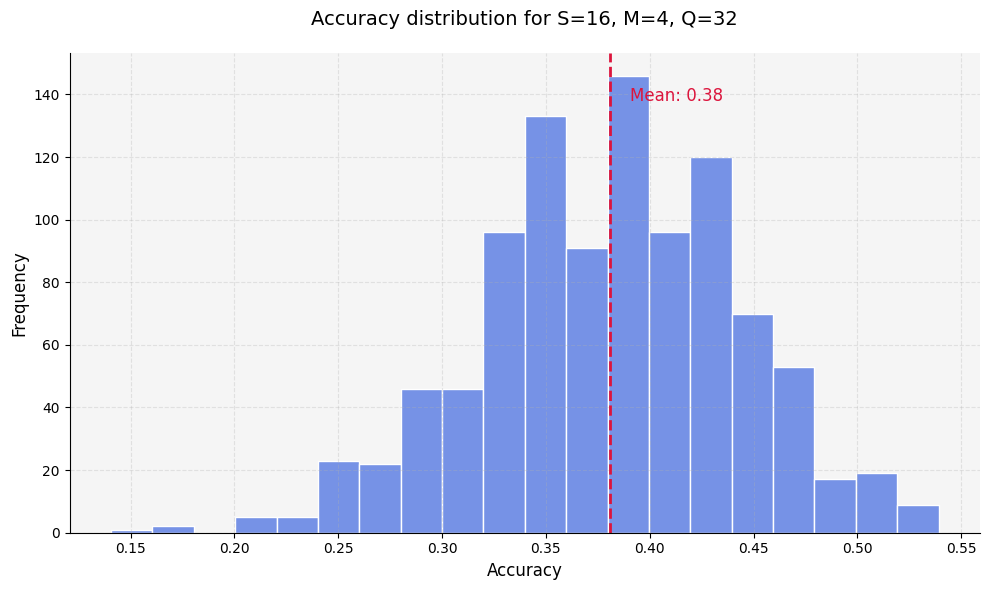

In [169]:
create_accuracy_hist_plot(model, S=16, Q=32, M=4, num_experiments=1000)

In [170]:
def create_S_lineplot(model, S, Q, M, num_experiments=10):
    all_accuracies = {s: [] for s in S}
    
    for s in S:
        batch_size = s + Q
        data_loaders = create_class_dataloaders(get_test_dataset_path(), batch_size, 2)
        data_loaders, class_names = data_loaders
        
        for _ in range(num_experiments):
            acc = calculate_avg_accuracy(model, data_loaders, class_names, s, Q, M)
            all_accuracies[s].append(acc)
    
    plt.figure(figsize=(10, 6))
    ax = sns.boxplot(
        x=[str(s) for s in S for _ in range(num_experiments)],
        y=[acc for s in S for acc in all_accuracies[s]],
        showmeans=True,
        meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"red"}
    )
    
    medians = [np.median(all_accuracies[s]) for s in S]
    ax.plot(range(len(S)), medians, color='red', marker='o', linestyle='--')
    
    plt.title(f'Accuracy vs Support Examples (Q={Q}, M={M})')
    plt.xlabel('Number of Support Examples (S)')
    plt.ylabel('Accuracy')
    
    plt.tight_layout()
    plt.show()

Traceback (most recent call last):
  File "/home/dawid/.pyenv/versions/3.11.8/lib/python3.11/multiprocessing/util.py", line 303, in _run_finalizers
    finalizer()
  File "/home/dawid/.pyenv/versions/3.11.8/lib/python3.11/multiprocessing/util.py", line 227, in __call__
    res = self._callback(*self._args, **self._kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dawid/.pyenv/versions/3.11.8/lib/python3.11/multiprocessing/util.py", line 136, in _remove_temp_dir
    rmtree(tempdir, onerror=onerror)
  File "/home/dawid/.pyenv/versions/3.11.8/lib/python3.11/shutil.py", line 763, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/home/dawid/.pyenv/versions/3.11.8/lib/python3.11/shutil.py", line 761, in rmtree
    os.rmdir(path, dir_fd=dir_fd)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-y9088rq3'
Traceback (most recent call last):
  File "/home/dawid/.pyenv/versions/3.11.8/lib/python3.11/multiprocessing/util.py", line 303, in _run_finalizers
   

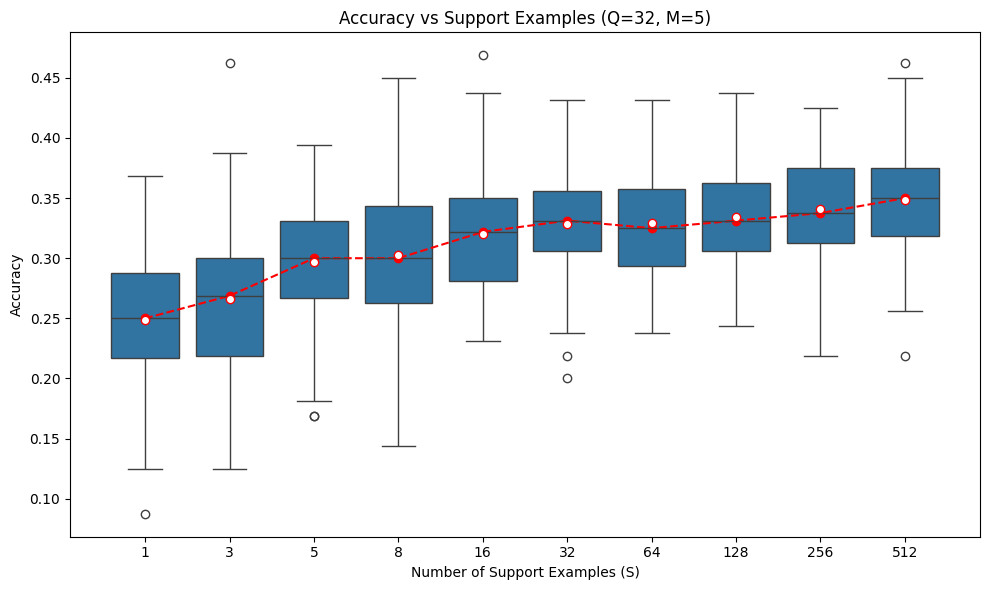

In [171]:
create_S_lineplot(model, S=[1,3,5,8,16,32,64,128, 256, 512], Q=32, M=5, num_experiments=100)